In [132]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Constants

In [133]:
region_name = "AICE_Barents_domain" # This can be "AICE_Barents_domain", "Greenland_sea", "Svalbard", "Barents_sea"
#
lead_times = [0,1,2,3,4,5,6,7,8,9]
#
paths = {}
paths["stats_with_Barents"] = "/lustre/storeA/users/cyrilp/AICE/Stats/Barents_AICE_domain/"
paths["stats_without_Barents"] = "/lustre/storeA/users/cyrilp/AICE/Stats/AICE_domain/"
paths["figures"] = "/lustre/storeA/users/cyrilp/AICE/Figures/Paper/"
#
colors = {}
colors["AICE"] = "blue"
colors["Barents_AA"] = "k"
colors["Barents_ensemble_mean"] = "k"
colors["Barents_members"] = "lightgray"
colors["Barents_bias_corrected_AA"] = "green"
colors["Barents_bias_corrected_ensemble_mean"] = "green"
colors["Barents_bias_corrected_members"] = "lightgreen"
#colors["Barents_SPS"] = "green"
colors["Persistence_AMSR2"] = "red"
colors["Persistence_ice_charts"] = "magenta"
colors["Anomaly_persistence"] = "purple"
#
sizefont = 18
sizefont_legend = 20
linewidth = 2
bar_width = 0.25
#
date_min_select = "20240321"
date_max_select = "20250312"
#
lead_times_seasonal = [0,2]

In [134]:
def make_stats(lead_times, paths, date_min_select, date_max_select, with_Barents):
    Scores = {}
    Monthly_scores = {}
    Frac_improved = {}
    #
    for ds_ref in ["AMSR2", "ice_charts"]:
        for lt, leadtime in enumerate(lead_times):
            if with_Barents == True:
                filename_dataset = paths["stats_with_Barents"] + "Scores_ice_edge_reference_" + ds_ref + "_lead_time_" + "{:01d}".format(leadtime) + ".txt"
            else:
                filename_dataset = paths["stats_without_Barents"] + "Scores_ice_edge_reference_" + ds_ref + "_lead_time_" + "{:01d}".format(leadtime) + ".txt"  
            #
            if os.path.isfile(filename_dataset):
                Dataset = pd.read_csv(filename_dataset, delimiter = "\t")
                Dataset = Dataset.loc[:, ~Dataset.columns.str.contains("^Unnamed")]  
                if ds_ref == "AMSR2":
                    Dataset = Dataset.drop(columns = ["RMSE_Persistence_ice_charts"])
                    Dataset = Dataset.drop(columns = ["IIEE_distance_Persistence_ice_charts"])
                Dataset = Dataset.dropna()  # Remove all rows with at least one nan 
                list_dates = pd.to_datetime(Dataset["start_date"], format = "%Y%m%d")
                df_month = list_dates.dt.month
                idx_dates = np.logical_and(list_dates >= pd.to_datetime(date_min_select, format="%Y%m%d"), list_dates <= pd.to_datetime(date_max_select, format="%Y%m%d"))
                print(ds_ref, len(list_dates[idx_dates == True]))
                #
                for var in Dataset:
                    if "_date" not in var:
                        if lt == 0:
                            Scores[ds_ref + "_" + var] = np.full(len(lead_times), np.nan)
                            if "IIEE" in var:
                                Frac_improved[ds_ref + "_" + var] = np.full(len(lead_times), np.nan)
                            elif "RMSE" in var:
                                Frac_improved[ds_ref + "_" + var] = np.full(len(lead_times), np.nan)
                        Scores[ds_ref + "_" + var][lt] = np.mean(Dataset[var][idx_dates == True])
                        #
                        if lt == 0:
                            Monthly_scores[ds_ref + "_" + var] = np.full((len(lead_times), 12), np.nan)
                        for month in range(1, 13):
                            idx_month = (df_month == month)
                            Monthly_scores[ds_ref + "_" + var][lt, month - 1] = np.mean(Dataset[var][idx_month == True])
                #
                for var in Dataset:
                    if "IIEE" in var:
                        persistence_ref = Dataset["IIEE_distance_Persistence_" + ds_ref][idx_dates == True]
                        Frac_improved[ds_ref + "_" + var][lt] = 100 * np.sum(Dataset[var][idx_dates == True] < persistence_ref) / len(persistence_ref)
                    elif "RMSE" in var:
                        persistence_ref = Dataset["RMSE_Persistence_" + ds_ref][idx_dates == True]
                        Frac_improved[ds_ref + "_" + var][lt] = 100 * np.sum(Dataset[var][idx_dates == True] < persistence_ref) / len(persistence_ref)
    # 
    return(Scores, Monthly_scores, Frac_improved)

In [135]:
def make_figure_IIEE(Scores_with_Barents, lead_times, paths, colors, date_min_select, date_max_select, region_name, saving = False):
    lead_times_fig = [str(x) for x in (np.array(lead_times) + 1)]
    #
    plt.figure()
    plt.rc("xtick", labelsize = sizefont)
    plt.rc("ytick", labelsize = sizefont)
    fig, ax = plt.subplots(2, 3, figsize = (20, 15), facecolor = "w", edgecolor = "k")
    fig.suptitle(date_min_select[0:4] + "-" + date_min_select[4:6] + "-" + date_min_select[6:8] + " to " + date_max_select[0:4] + "-" + date_max_select[4:6] + "-" + date_max_select[6:8], fontsize = 1.5 * sizefont)
    fig.subplots_adjust(hspace = 0.25, wspace = 0.18)
    #
    ax = plt.subplot(231)
    l = ax.plot(lead_times_fig, Scores_without_Barents["AMSR2_RMSE_AICE"], color = colors["AICE"], label = "MET-AICE", linewidth = linewidth)
    l = ax.plot(lead_times_fig, Scores_without_Barents["AMSR2_RMSE_Persistence_AMSR2"], color = colors["Persistence_AMSR2"], label = "Persistence AMSR2 observations", linewidth = linewidth)
    l = ax.plot(lead_times_fig, Scores_without_Barents["AMSR2_RMSE_Anomaly_persistence"], color = colors["Anomaly_persistence"], label = "Anomaly_persistence", linewidth = linewidth)
    ax.grid()
    ax.set_title("AMSR2 observations as reference \n RMSE of the sea ice concentration", fontsize = sizefont, fontweight = "bold")
    ax.set_ylabel("Root mean square error (%)", fontsize = sizefont)
    ax.set_xlabel("Lead time (days)", fontsize = sizefont)
    ax.set_ylim([5, 17])
    ax.text(-0.1,-0.05, "a)", fontsize = sizefont, ha = "left", transform = ax.transAxes) 
    #
    ax = plt.subplot(232)
    l = ax.plot(lead_times_fig, 0.001 * Scores_without_Barents["AMSR2_IIEE_distance_AICE"], color = colors["AICE"], label = "MET-AICE", linewidth = linewidth)
    l = ax.plot(lead_times_fig, 0.001 * Scores_without_Barents["AMSR2_IIEE_distance_Persistence_AMSR2"], color = colors["Persistence_AMSR2"], label = "Persistence AMSR2 observations", linewidth = linewidth)
    l = ax.plot(lead_times_fig, 0.001 * Scores_without_Barents["AMSR2_IIEE_distance_Anomaly_persistence"], color = colors["Anomaly_persistence"], label = "Anomaly_persistence", linewidth = linewidth)
    ax.grid()
    ax.set_title("AMSR2 observations as reference \n Ice edge distance error", fontsize = sizefont, fontweight = "bold")
    ax.set_ylabel("IIEE / ice edge length (km)", fontsize = sizefont)
    ax.set_xlabel("Lead time (days)", fontsize = sizefont)
    ax.set_ylim([5, 24])
    ax.text(-0.1,-0.05, "b)", fontsize = sizefont, ha = "left", transform = ax.transAxes) 
    #
    ax = plt.subplot(233)
    l = ax.plot(lead_times_fig, 0.001 * Scores_without_Barents["ice_charts_IIEE_distance_AICE"], color = colors["AICE"], label = "MET-AICE", linewidth = linewidth)
    l = ax.plot(lead_times_fig, 0.001 * Scores_without_Barents["ice_charts_IIEE_distance_Persistence_AMSR2"], color = colors["Persistence_AMSR2"], label = "Persistence AMSR2 observations", linewidth = linewidth)
    l = ax.plot(lead_times_fig, 0.001 * Scores_without_Barents["ice_charts_IIEE_distance_Persistence_ice_charts"], color = colors["Persistence_ice_charts"], label = "Persistence ice charts", linewidth = linewidth)
    l = ax.plot(lead_times_fig, 0.001 * Scores_without_Barents["ice_charts_IIEE_distance_Anomaly_persistence"], color = colors["Anomaly_persistence"], label = "Anomaly_persistence", linewidth = linewidth)
    ax.grid()
    ax.set_title("Ice charts as reference \n Ice edge distance error", fontsize = sizefont, fontweight = "bold")
    ax.set_ylabel("IIEE / ice edge length (km)", fontsize = sizefont)
    ax.set_xlabel("Lead time (days)", fontsize = sizefont)
    ax.set_ylim([8, 38])
    ax.text(-0.1,-0.05, "c)", fontsize = sizefont, ha = "left", transform = ax.transAxes) 
    #
    ax = plt.subplot(234)
    for me in range(0, 6):
        member = "{:02d}".format(me)
        if member == "00":
            l = ax.plot(lead_times_fig, Scores_with_Barents["AMSR2_RMSE_Barents_member_" + member], color = colors["Barents_AA"], label = "Barents member forced by AROME-Arctic", linewidth = linewidth)
            l = ax.plot(lead_times_fig, Scores_with_Barents["AMSR2_RMSE_Barents_bias_corrected_member_" + member], color = colors["Barents_bias_corrected_AA"], label = "Barents member forced by AROME-Arctic, bias corrected", linewidth = linewidth)
        else:
            if member == "01":
                l = ax.plot(lead_times_fig, Scores_with_Barents["AMSR2_RMSE_Barents_member_" + member], color = colors["Barents_members"], label = "Barents members forced by ECMWF IFS", linewidth = linewidth)
                l = ax.plot(lead_times_fig, Scores_with_Barents["AMSR2_RMSE_Barents_bias_corrected_member_" + member], color = colors["Barents_bias_corrected_members"], label = "Barents member forced by ECMWF IFS, bias corrected", linewidth = linewidth)
            else:
                l = ax.plot(lead_times_fig, Scores_with_Barents["AMSR2_RMSE_Barents_member_" + member], color = colors["Barents_members"], linewidth = linewidth)
    #l = ax.plot(lead_times_fig, Scores_with_Barents["AMSR2_RMSE_ensemble_mean_Barents"], color = colors["Barents_ensemble_mean"], linestyle = "--", label = "Barents ensemble mean", linewidth = linewidth)
    l = ax.plot(lead_times_fig, Scores_with_Barents["AMSR2_RMSE_AICE"], color = colors["AICE"], label = "MET-AICE", linewidth = linewidth)
    l = ax.plot(lead_times_fig, Scores_with_Barents["AMSR2_RMSE_Persistence_AMSR2"], color = colors["Persistence_AMSR2"], label = "Persistence AMSR2 observations", linewidth = linewidth)
    l = ax.plot(lead_times_fig, Scores_with_Barents["AMSR2_RMSE_Anomaly_persistence"], color = colors["Anomaly_persistence"], label = "Anomaly_persistence", linewidth = linewidth)
    ax.grid()
    ax.set_title("AMSR2 observations as reference \n RMSE of the sea ice concentration", fontsize = sizefont, fontweight = "bold")
    ax.set_ylabel("Root mean square error (%)", fontsize = sizefont)
    ax.set_xlabel("Lead time (days)", fontsize = sizefont)
    ax.set_ylim([5, 17])
    ax.text(-0.1,-0.05, "d)", fontsize = sizefont, ha = "left", transform = ax.transAxes) 
    #
    ax = plt.subplot(235)
    for me in range(0, 6):
        member = "{:02d}".format(me)
        if member == "00":
            l = ax.plot(lead_times_fig, 0.001 * Scores_with_Barents["AMSR2_IIEE_distance_Barents_member_" + member], color = colors["Barents_AA"], label = "Barents member forced by AROME-Arctic", linewidth = linewidth)
            l = ax.plot(lead_times_fig, 0.001 * Scores_with_Barents["AMSR2_IIEE_distance_Barents_bias_corrected_member_" + member], color = colors["Barents_bias_corrected_AA"], label = "Barents member forced by AROME-Arctic, bias corrected", linewidth = linewidth)
        else:
            if member == "01":
                l = ax.plot(lead_times_fig, 0.001 * Scores_with_Barents["AMSR2_IIEE_distance_Barents_member_" + member], color = colors["Barents_members"], label = "Barents members forced by ECMWF IFS", linewidth = linewidth)
                l = ax.plot(lead_times_fig, 0.001 * Scores_with_Barents["AMSR2_IIEE_distance_Barents_bias_corrected_member_" + member], color = colors["Barents_bias_corrected_members"], label = "Barents member forced by ECMWF IFS, bias corrected", linewidth = linewidth)
            else:
                l = ax.plot(lead_times_fig, 0.001 * Scores_with_Barents["AMSR2_IIEE_distance_Barents_member_" + member], color = colors["Barents_members"], linewidth = linewidth)
                l = ax.plot(lead_times_fig, 0.001 * Scores_with_Barents["AMSR2_IIEE_distance_Barents_bias_corrected_member_" + member], color = colors["Barents_bias_corrected_members"], linewidth = linewidth)
    #l = ax.plot(lead_times_fig, 0.001 * Scores_with_Barents["AMSR2_IIEE_distance_ensemble_mean_Barents"], color = colors["Barents_ensemble_mean"], linestyle = "--", label = "Barents ensemble mean", linewidth = linewidth)
    #l = ax.plot(lead_times_fig, 0.001 * Scores_with_Barents["AMSR2_SPS_distance_Barents"], color = colors["Barents_SPS"], linestyle = "solid", label = "Barents - SPS / ice edge length", linewidth = linewidth)
    l = ax.plot(lead_times_fig, 0.001 * Scores_with_Barents["AMSR2_IIEE_distance_AICE"], color = colors["AICE"], label = "MET-AICE", linewidth = linewidth)
    l = ax.plot(lead_times_fig, 0.001 * Scores_with_Barents["AMSR2_IIEE_distance_Persistence_AMSR2"], color = colors["Persistence_AMSR2"], label = "Persistence AMSR2 observations", linewidth = linewidth)
    l = ax.plot(lead_times_fig, 0.001 * Scores_with_Barents["AMSR2_IIEE_distance_Anomaly_persistence"], color = colors["Anomaly_persistence"], label = "Anomaly_persistence", linewidth = linewidth)
    ax.grid()
    ax.set_title("AMSR2 observations as reference \n Ice edge distance error", fontsize = sizefont, fontweight = "bold")
    ax.set_ylabel("IIEE / ice edge length (km)", fontsize = sizefont)
    ax.set_xlabel("Lead time (days)", fontsize = sizefont)
    ax.set_ylim([5, 24])
    ax.text(-0.1,-0.05, "e)", fontsize = sizefont, ha = "left", transform = ax.transAxes) 
    #
    ax = plt.subplot(236)
    for me in range(0, 6):
        member = "{:02d}".format(me)
        if member == "00":
            l = ax.plot(lead_times_fig, 0.001 * Scores_with_Barents["ice_charts_IIEE_distance_Barents_member_" + member], color = colors["Barents_AA"], label = "Barents member forced by AROME-Arctic", linewidth = linewidth)
            l = ax.plot(lead_times_fig, 0.001 * Scores_with_Barents["ice_charts_IIEE_distance_Barents_bias_corrected_member_" + member], color = colors["Barents_bias_corrected_AA"], label = "Barents member forced by AROME-Arctic, bias corrected", linewidth = linewidth)
        else:
            if member == "01":
                l = ax.plot(lead_times_fig, 0.001 * Scores_with_Barents["ice_charts_IIEE_distance_Barents_member_" + member], color = colors["Barents_members"], label = "Barents members forced by ECMWF IFS", linewidth = linewidth)
                l = ax.plot(lead_times_fig, 0.001 * Scores_with_Barents["ice_charts_IIEE_distance_Barents_bias_corrected_member_" + member], color = colors["Barents_bias_corrected_members"], label = "Barents member forced by ECMWF IFS, bias corrected", linewidth = linewidth)
            else:
                l = ax.plot(lead_times_fig, 0.001 * Scores_with_Barents["ice_charts_IIEE_distance_Barents_member_" + member], color = colors["Barents_members"], linewidth = linewidth)
                l = ax.plot(lead_times_fig, 0.001 * Scores_with_Barents["ice_charts_IIEE_distance_Barents_bias_corrected_member_" + member], color = colors["Barents_bias_corrected_members"], linewidth = linewidth)
    #l = ax.plot(lead_times_fig, 0.001 * Scores_with_Barents["ice_charts_IIEE_distance_ensemble_mean_Barents"], color = colors["Barents_ensemble_mean"], linestyle = "--", label = "Barents ensemble mean", linewidth = linewidth)
    #l = ax.plot(lead_times_fig, 0.001 * Scores_with_Barents["ice_charts_SPS_distance_Barents"], color = colors["Barents_SPS"], linestyle = "solid", label = "Barents - SPS / ice edge length", linewidth = linewidth)
    l = ax.plot(lead_times_fig, 0.001 * Scores_with_Barents["ice_charts_IIEE_distance_AICE"], color = colors["AICE"], label = "MET-AICE", linewidth = linewidth)
    l = ax.plot(lead_times_fig, 0.001 * Scores_with_Barents["ice_charts_IIEE_distance_Persistence_AMSR2"], color = colors["Persistence_AMSR2"], label = "Persistence AMSR2 observations", linewidth = linewidth)
    l = ax.plot(lead_times_fig, 0.001 * Scores_with_Barents["ice_charts_IIEE_distance_Persistence_ice_charts"], color = colors["Persistence_ice_charts"], label = "Persistence ice charts", linewidth = linewidth)
    l = ax.plot(lead_times_fig, 0.001 * Scores_with_Barents["ice_charts_IIEE_distance_Anomaly_persistence"], color = colors["Anomaly_persistence"], label = "Anomaly_persistence", linewidth = linewidth)
    ax.grid()
    ax.set_title("Ice charts as reference \n Ice edge distance error", fontsize = sizefont, fontweight = "bold")
    ax.set_ylabel("IIEE / ice edge length (km)", fontsize = sizefont)
    ax.set_xlabel("Lead time (days)", fontsize = sizefont)
    ax.set_ylim([8, 38])
    ax.text(-0.1,-0.05, "f)", fontsize = sizefont, ha = "left", transform = ax.transAxes) 
    #
    ax.legend(fontsize = sizefont_legend, loc = "lower left", ncol = 1, bbox_to_anchor = (1.0, 0, 0.5, 0.5))
    plt.subplots_adjust(top = 0.85)
    #
    if saving == True:
        plt.savefig(paths["figures"] + "Scores_ice_edge_AICE_Barents_" + date_min_select + "_" + date_max_select + "_" + region_name + ".png", bbox_inches = "tight")
    else:
        plt.show()

In [136]:
def make_figure_seasonal_variability_AMSR2_ref(Monthly_scores, lead_times_seasonal, paths, colors, date_min_select, date_max_select, region_name, saving = False):
    #
    nrows = 2
    ncolumns = len(lead_times_seasonal)
    #
    month_ticks = ["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"]
    caption_ticks = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)", "i)", "j)"]
    #
    plt.figure()
    plt.rc("xtick", labelsize = sizefont)
    plt.rc("ytick", labelsize = sizefont)
    fig, ax = plt.subplots(nrows, ncolumns, figsize = (ncolumns * 8 , nrows * 7), facecolor = "w", edgecolor = "k")
    fig.subplots_adjust(hspace = 0.25, wspace = 0.18)
    fig.suptitle(region_name.replace("_", " ") + " " + date_min_select[0:4] + "-" + date_min_select[4:6] + "-" + date_min_select[6:8] + " to " + date_max_select[0:4] + "-" + date_max_select[4:6] + "-" + date_max_select[6:8], fontsize = 1.5 * sizefont)
    ax = ax.ravel()
    #
    for lt, leadtime in enumerate(lead_times_seasonal):
        lt_str = "_lt_" + str(leadtime + 1)
        for me in range(0, 6):
            member = "{:02d}".format(me)
            if member == "00":
                l1 = ax[lt].plot(np.arange(12) + 1, Monthly_scores["AMSR2_RMSE_Barents_member_" + member][leadtime,:], color = colors["Barents_AA"], label = "Barents member forced by AROME-Arctic", linewidth = linewidth)
            else:
                if member == "01":
                    l2 = ax[lt].plot(np.arange(12) + 1, Monthly_scores["AMSR2_RMSE_Barents_member_" + member][leadtime,:], color = colors["Barents_members"], label = "Barents members forced by ECMWF IFS", linewidth = linewidth)
                else:
                    l3 = ax[lt].plot(np.arange(12) + 1, Monthly_scores["AMSR2_RMSE_Barents_member_" + member][leadtime,:], color = colors["Barents_members"], linewidth = linewidth)
        l4 = ax[lt].plot(np.arange(12) + 1, Monthly_scores["AMSR2_RMSE_ensemble_mean_Barents"][leadtime,:], color = colors["Barents_ensemble_mean"], linestyle = "--", label = "Barents ensemble mean", linewidth = linewidth)
        l5 = ax[lt].plot(np.arange(12) + 1, Monthly_scores["AMSR2_RMSE_AICE"][leadtime,:], color = colors["AICE"], label = "MET-AICE", linewidth = linewidth)
        l6 = ax[lt].plot(np.arange(12) + 1, Monthly_scores["AMSR2_RMSE_Persistence_AMSR2"][leadtime,:], color = colors["Persistence_AMSR2"], label = "Persistence AMSR2 observations", linewidth = linewidth)
        ax[lt].set_xticks(np.arange(len(month_ticks)) + 1, month_ticks, rotation = 0, ha = 'center', fontsize = sizefont)
        ax[lt].set_xlabel("Forecast start date (month)", fontsize = sizefont)
        ax[lt].grid(alpha = 0.4)
        #
        ax[lt].set_ylabel("RMSE (%)", fontsize = sizefont)
        if leadtime == 0:
            ax[lt].set_title("AMSR2 observations as reference \n RMSE Lead time: " + str(leadtime + 1) + " day", fontsize = sizefont, fontweight = "bold")
        else:
            ax[lt].set_title("AMSR2 observations as reference \n RMSE Lead time: " + str(leadtime + 1) + " days", fontsize = sizefont, fontweight = "bold")
        #
        lns = l1 + l2 + l3 + l4 + l5 + l6
        labs = [l.get_label() for l in lns]
        #
        #ax[lt].text(-0.15,-0.07, caption_ticks[lt], fontsize = sizefont, ha = "left", transform = ax[lt].transAxes) 
        #if lt == 0:
        #    ax[lt].legend(lns, labs, fontsize = sizefont_legend, loc = "best")
    #
    for lt, leadtime in enumerate(lead_times_seasonal):
        lt_str = "_lt_" + str(leadtime + 1)
        for me in range(0, 6):
            member = "{:02d}".format(me)
            if member == "00":
                l1 = ax[lt + ncolumns].plot(np.arange(12) + 1, 0.001 * Monthly_scores["AMSR2_IIEE_distance_Barents_member_" + member][leadtime,:], color = colors["Barents_AA"], label = "Barents member forced by AROME-Arctic", linewidth = linewidth)
            else:
                if member == "01":
                    l2 = ax[lt + ncolumns].plot(np.arange(12) + 1, 0.001 * Monthly_scores["AMSR2_IIEE_distance_Barents_member_" + member][leadtime,:], color = colors["Barents_members"], label = "Barents members forced by ECMWF IFS", linewidth = linewidth)
                else:
                    l3 = ax[lt + ncolumns].plot(np.arange(12) + 1, 0.001 * Monthly_scores["AMSR2_IIEE_distance_Barents_member_" + member][leadtime,:], color = colors["Barents_members"], linewidth = linewidth)
        #l4 = ax[lt + ncolumns].plot(np.arange(12) + 1, 0.001 * Monthly_scores["AMSR2_IIEE_distance_ensemble_mean_Barents"][leadtime,:], color = colors["Barents_ensemble_mean"], linestyle = "--", label = "Barents ensemble mean", linewidth = linewidth)
        #l5 = ax[lt + ncolumns].plot(np.arange(12) + 1, 0.001 * Monthly_scores["AMSR2_SPS_distance_Barents"][leadtime,:], color = colors["Barents_SPS"], linestyle = "solid", label = "Barents - SPS / ice edge length", linewidth = linewidth)
        l6 = ax[lt + ncolumns].plot(np.arange(12) + 1, 0.001 * Monthly_scores["AMSR2_IIEE_distance_AICE"][leadtime,:], color = colors["AICE"], label = "MET-AICE", linewidth = linewidth)
        l7 = ax[lt + ncolumns].plot(np.arange(12) + 1, 0.001 * Monthly_scores["AMSR2_IIEE_distance_Persistence_AMSR2"][leadtime,:], color = colors["Persistence_AMSR2"], label = "Persistence AMSR2 observations", linewidth = linewidth)
        ax[lt + ncolumns].set_xticks(np.arange(len(month_ticks)) + 1, month_ticks, rotation = 0, ha = 'center', fontsize = sizefont)
        ax[lt + ncolumns].set_xlabel("Forecast start date (month)", fontsize = sizefont)
        ax[lt + ncolumns].grid(alpha = 0.4)
        #
        ax[lt + ncolumns].set_ylabel("Ice edge distance error (km)", fontsize = sizefont)
        if leadtime == 0:
            ax[lt + ncolumns].set_title("AMSR2 observations as reference \n Ice edge distance error Lead time: " + str(leadtime + 1) + " day", fontsize = sizefont, fontweight = "bold")
        else:
            ax[lt + ncolumns].set_title("AMSR2 observations as reference \n Ice edge distance error Lead time: " + str(leadtime + 1) + " days", fontsize = sizefont, fontweight = "bold")
        #
        lns = l1 + l2 + l3 + l6 + l7
        labs = [l.get_label() for l in lns]
        #
        #ax[lt + ncolumns].text(-0.15,-0.07, caption_ticks[lt + ncolumns], fontsize = sizefont, ha = "left", transform = ax[lt + ncolumns].transAxes) 
        if lt == ncolumns - 1:
            ax[lt + ncolumns].legend(fontsize = sizefont_legend, loc = "lower left", ncol = 1, bbox_to_anchor = (1.0, 0, 0.5, 0.5))
    #
    if saving == True:
        plt.savefig(paths["figures"] + "Seasonal_variability_AMSR2_ref_" + date_min_select + "_" + date_max_select + ".png", bbox_inches = "tight", dpi = 300)
    else:
        plt.show()

In [137]:
def make_figure_seasonal_variability_ice_charts_ref(Monthly_scores, lead_times_seasonal, paths, colors, date_min_select, date_max_select, region_name, saving = False):
    #
    nrows = 1
    ncolumns = len(lead_times_seasonal)
    #
    month_ticks = ["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"]
    caption_ticks = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)", "i)", "j)"]
    #
    plt.figure()
    plt.rc("xtick", labelsize = sizefont)
    plt.rc("ytick", labelsize = sizefont)
    fig, ax = plt.subplots(nrows, ncolumns, figsize = (ncolumns * 8 , nrows * 9), facecolor = "w", edgecolor = "k")
    fig.subplots_adjust(hspace = 0.25, wspace = 0.18)
    fig.suptitle(region_name.replace("_", " ") + " " + date_min_select[0:4] + "-" + date_min_select[4:6] + "-" + date_min_select[6:8] + " to " + date_max_select[0:4] + "-" + date_max_select[4:6] + "-" + date_max_select[6:8], fontsize = 1.5 * sizefont)
    ax = ax.ravel()
    #
    for lt, leadtime in enumerate(lead_times_seasonal):
        lt_str = "_lt_" + str(leadtime + 1)
        for me in range(0, 6):
            member = "{:02d}".format(me)
            if member == "00":
                l1 = ax[lt].plot(np.arange(12) + 1, 0.001 * Monthly_scores["ice_charts_IIEE_distance_Barents_member_" + member][leadtime,:], color = colors["Barents_AA"], label = "Barents member forced by AROME-Arctic", linewidth = linewidth)
            else:
                if member == "01":
                    l2 = ax[lt].plot(np.arange(12) + 1, 0.001 * Monthly_scores["ice_charts_IIEE_distance_Barents_member_" + member][leadtime,:], color = colors["Barents_members"], label = "Barents members forced by ECMWF IFS", linewidth = linewidth)
                else:
                    l3 = ax[lt].plot(np.arange(12) + 1, 0.001 * Monthly_scores["ice_charts_IIEE_distance_Barents_member_" + member][leadtime,:], color = colors["Barents_members"], linewidth = linewidth)
        #l4 = ax[lt].plot(np.arange(12) + 1, 0.001 * Monthly_scores["ice_charts_IIEE_distance_ensemble_mean_Barents"][leadtime,:], color = colors["Barents_ensemble_mean"], linestyle = "--", label = "Barents ensemble mean", linewidth = linewidth)
        #l5 = ax[lt].plot(np.arange(12) + 1, 0.001 * Monthly_scores["ice_charts_SPS_distance_Barents"][leadtime,:], color = colors["Barents_SPS"], linestyle = "solid", label = "Barents - SPS / ice edge length", linewidth = linewidth)
        l6 = ax[lt].plot(np.arange(12) + 1, 0.001 * Monthly_scores["ice_charts_IIEE_distance_AICE"][leadtime,:], color = colors["AICE"], label = "MET-AICE", linewidth = linewidth)
        l7 = ax[lt].plot(np.arange(12) + 1, 0.001 * Monthly_scores["ice_charts_IIEE_distance_Persistence_AMSR2"][leadtime,:], color = colors["Persistence_AMSR2"], label = "Persistence AMSR2 observations", linewidth = linewidth)
        l8 = ax[lt].plot(np.arange(12) + 1, 0.001 * Monthly_scores["ice_charts_IIEE_distance_Persistence_ice_charts"][leadtime,:], color = colors["Persistence_ice_charts"], label = "Persistence ice charts", linewidth = linewidth)
        ax[lt].set_xticks(np.arange(len(month_ticks)) + 1, month_ticks, rotation = 0, ha = 'center', fontsize = sizefont)
        ax[lt].set_xlabel("Forecast start date (month)", fontsize = sizefont)
        ax[lt].grid(alpha = 0.4)
        #
        ax[lt].set_ylabel("Ice edge distance error (km)", fontsize = sizefont)
        if leadtime == 0:
            ax[lt].set_title("Ice charts as reference \n Ice edge distance error Lead time: " + str(leadtime + 1) + " day", fontsize = sizefont, fontweight = "bold")
        else:
            ax[lt].set_title("Ice charts as reference \n Ice edge distance error Lead time: " + str(leadtime + 1) + " days", fontsize = sizefont, fontweight = "bold")
        #
        lns = l1 + l2 + l3 + l6 + l7 + l8
        labs = [l.get_label() for l in lns]
        #
        #ax[lt + ncolumns].text(-0.15,-0.07, caption_ticks[lt + ncolumns], fontsize = sizefont, ha = "left", transform = ax[lt + ncolumns].transAxes) 
        if lt == ncolumns - 1:
            ax[lt].legend(fontsize = sizefont_legend, loc = "lower left", ncol = 1, bbox_to_anchor = (1.0, 0, 0.5, 0.5))
    #
    if saving == True:
        plt.savefig(paths["figures"] + "Seasonal_variability_ice_charts_ref_" + date_min_select + "_" + date_max_select + ".png", bbox_inches = "tight", dpi = 300)
    else:
        plt.show()

In [138]:
def make_figure_fraction_improved(Frac_improved, lead_times, paths, colors, date_min_select, date_max_select, region_name, saving = False):
    lead_times_fig = [str(x) for x in (np.array(lead_times) + 1)]
    #
    alpha = 1
    list_datasets = ["AICE", "Barents_member_00", "ensemble_mean_Barents"]
    colors_freq = ["blue", "red", "green"]
    #
    plt.figure()
    plt.rc("xtick", labelsize = sizefont)
    plt.rc("ytick", labelsize = sizefont)
    fig, ax = plt.subplots(1, 3, figsize = (20, 7), facecolor = "w", edgecolor = "k")
    fig.subplots_adjust(hspace = 0.25, wspace = 0.25)
    fig.suptitle(region_name.replace("_", " ") + " " + date_min_select[0:4] + "-" + date_min_select[4:6] + "-" + date_min_select[6:8] + " to " + date_max_select[0:4] + "-" + date_max_select[4:6] + "-" + date_max_select[6:8], fontsize = 1.5 * sizefont)
    #
    ax = plt.subplot(131)
    for di, ds in enumerate(list_datasets):
        lead_times_i = np.array(lead_times) - 1 * bar_width + di * bar_width
        l = ax.bar(lead_times_i, Frac_improved["AMSR2_RMSE_" + ds], color = colors_freq[di], label = ds.replace("ensemble_mean_Barents", "Barents ensemble mean").replace("_", " ").replace("AICE", "MET-AICE"), width = bar_width, alpha = alpha)
    ax.set_title("AMSR2 observations as reference \n RMSE of the sea ice concentration", fontsize = sizefont, fontweight = "bold")
    ax.set_ylabel("Fraction of forecasts outperforming  \n persistence of AMSR2 observations (%)", fontsize = sizefont)
    ax.set_xlabel("Lead time (days)", fontsize = sizefont)
    ax.set_xticks(ticks = np.array(lead_times), labels = np.array(lead_times) + 1)
    #
    ax = plt.subplot(132)
    for di, ds in enumerate(list_datasets):
        lead_times_i = np.array(lead_times) - 1 * bar_width + di * bar_width
        l = ax.bar(lead_times_i, Frac_improved["AMSR2_IIEE_distance_" + ds], color = colors_freq[di], label = ds.replace("_", " ").replace("AICE", "MET-AICE"), width = bar_width, alpha = alpha)
    ax.set_title("AMSR2 observations as reference \n Ice edge distance error", fontsize = sizefont, fontweight = "bold")
    ax.set_ylabel("Fraction of forecasts outperforming  \n persistence of AMSR2 observations (%)", fontsize = sizefont)
    ax.set_xlabel("Lead time (days)", fontsize = sizefont)
    ax.set_xticks(ticks = np.array(lead_times), labels = np.array(lead_times) + 1)
    #
    ax = plt.subplot(133)
    for di, ds in enumerate(list_datasets):
        lead_times_i = np.array(lead_times) - 1 * bar_width + di * bar_width
        l = ax.bar(lead_times_i, Frac_improved["ice_charts_IIEE_distance_" + ds], color = colors_freq[di], label = ds.replace("_", " ").replace("AICE", "MET-AICE"), width = bar_width, alpha = alpha)
    ax.set_title("Ice charts as reference \n Ice edge distance error", fontsize = sizefont, fontweight = "bold")
    ax.set_ylabel("Fraction of forecasts outperforming  \n persistence of ice charts (%)", fontsize = sizefont)
    ax.set_xlabel("Lead time (days)", fontsize = sizefont)
    ax.set_xticks(ticks = np.array(lead_times), labels = np.array(lead_times) + 1)
    #
    ax.legend(fontsize = sizefont_legend, loc = "lower left", ncol = 1, bbox_to_anchor = (1.0, 0, 0.5, 0.5))
    plt.subplots_adjust(top = 0.85)
    #
    if saving == True:
        plt.savefig(paths["figures"] + "Fraction_of_forecasts_improved_AICE_Barents_ice_edge_" + date_min_select + "_" + date_max_select + "_" + region_name + ".png", bbox_inches = "tight")
    else:
        plt.show()

AMSR2 317
AMSR2 314
AMSR2 308
AMSR2 291
AMSR2 312
AMSR2 312
AMSR2 311
AMSR2 309
AMSR2 308
AMSR2 307
ice_charts 164
ice_charts 122
ice_charts 116
ice_charts 106
ice_charts 115
ice_charts 155
ice_charts 195
ice_charts 159
ice_charts 122
ice_charts 117
AMSR2 332
AMSR2 332
AMSR2 330
AMSR2 328
AMSR2 327
AMSR2 326
AMSR2 325
AMSR2 323
AMSR2 322
AMSR2 321
ice_charts 168
ice_charts 125
ice_charts 126
ice_charts 122
ice_charts 120
ice_charts 161
ice_charts 202
ice_charts 163
ice_charts 124
ice_charts 123


<Figure size 640x480 with 0 Axes>

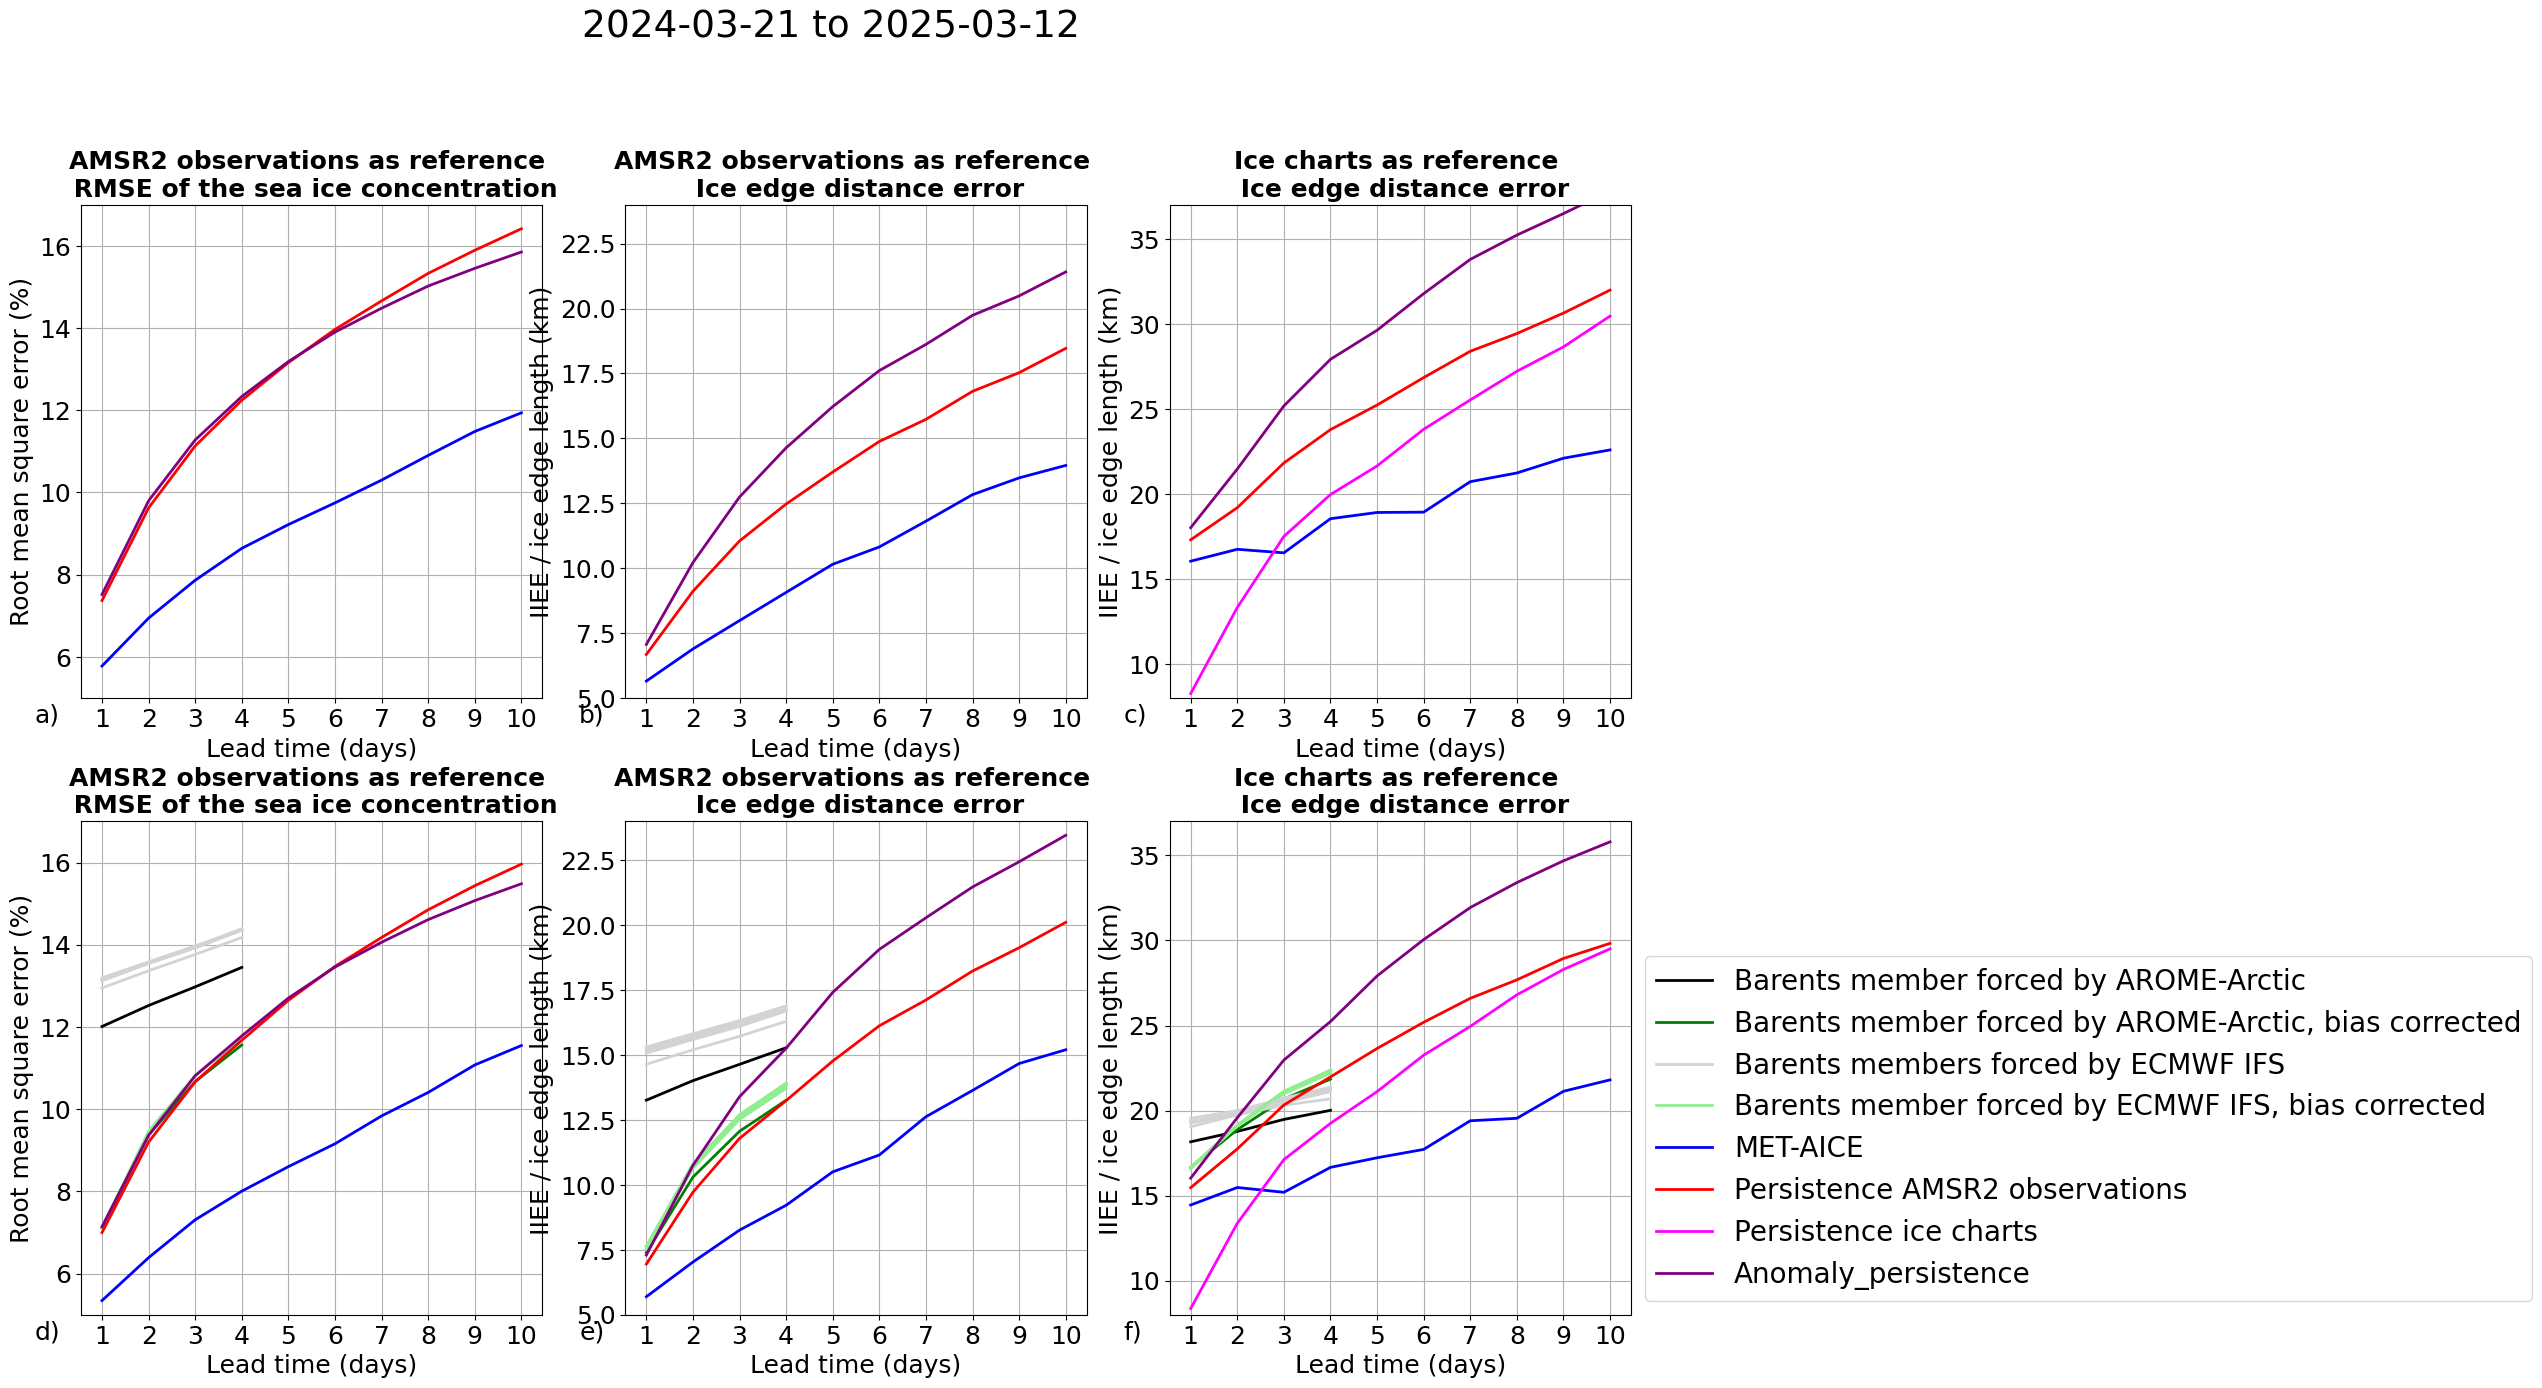

In [139]:
Scores_with_Barents, Monthly_scores_with_Barents, Frac_improved_with_Barents = make_stats(lead_times, paths, date_min_select, date_max_select, with_Barents = True)
Scores_without_Barents, Monthly_scores_without_Barents, Frac_improved_without_Barents = make_stats(lead_times, paths, date_min_select, date_max_select, with_Barents = False)
make_figure_IIEE(Scores_with_Barents, lead_times, paths, colors, date_min_select, date_max_select, region_name, saving = False)
#make_figure_seasonal_variability_AMSR2_ref(Monthly_scores, lead_times_seasonal, paths, colors, date_min_select, date_max_select, region_name, saving = True)
#make_figure_seasonal_variability_ice_charts_ref(Monthly_scores, lead_times_seasonal, paths, colors, date_min_select, date_max_select, region_name, saving = True)
#make_figure_fraction_improved(Frac_improved, lead_times, paths, colors, date_min_select, date_max_select, region_name, saving = True)